# Project 3: Image Recognition in Medical Treatment
## Diagnosing Skin Lesions using Machine Learning in Image Processing 
---

**Group 9: Aidan Stocks, Hugo Reinicke, Nicola Clark, Jonas-Mika Senghaas**

Submission: *19.04.2021* / Last Modified: *08.04.2021*

---

This notebook contains the step-by-step data science process performed on the *ISIC 2017* public test data and official training data on medical image recognition. The goal of this project was to extract and automatically analyse features from medical images of skin lesions in order to predict whether or not the person has ** using machine learning and image processing.

The initial data (containing the medical images, masked images and information on features and disease) was given for 150 medical images (equivalent to the public test data of the *ISIC 2017* challenge) by the project manager *Veronika *.
To develop more accurate models, we extended the initially given data by the official training data that could be obtained from the official [ISIC 2017 Website](https://challenge.isic-archive.com/data)

## Introduction
---
The amount of medical imaging - just as data in any other field - has increased tremendously within the last decade, making it more and more difficult to manually inspect medical images for diagnosis purposes.

Furthermore, people have proven to be hesitant of visiting doctors because of seemingly 'light' issues, which did not seem to be important enough to occupy a doctor's time. With skin diseases being especially effective in treatment if detected early, this is fatal. 
An easy-to-use app that implements automated detection of skin diseases from the sofa, would address this issue - ultimately saving lives.

## Running this Notebook
---
This notebook contains all code to reproduce the findings of the project as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of this project. In order to read in the data correctly, the global paths configured in the section `Constants` need to be correct. The following file structure - as prepared in the `submission.zip` - was followed throughout the project and is recommended to use (alternatively the paths in the section `Constants` can be adjusted):

```
*project tree structure*
```
*Note that the rest of the file structure as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of the project generates automatically*

## Required Libraries and Further Imports
---
Throughout the project, we will use a range of both built-in and external Python Libraries. This notebook will only run if all libraries and modules are correctly installed on your local machines. 
To install missing packages use `pip install <package_name>` (PIP (Python Package Index) is the central package management system, read more [here](https://pypi.org/project/pip/)). 

In case you desire further information about the used packages, click the following links to find detailed documentations:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [PIL](https://pillow.readthedocs.io/en/stable/)
- [SciKit Learn](https://scikit-learn.org/stable/)
- [SciKit Image](https://scikit-image.org/)
- [Scipy](https://www.scipy.org/)

In [1]:
%%capture
!pip install scikit-image
!pip install scikit-learn
!pip install pillow

In [2]:
# external libraries
import pandas as pd                                    # provides major datastructure pd.DataFrame() to store datasets
import numpy as np                                     # used for numerical calculations and fast array manipulations
import matplotlib.pyplot as plt                        # visualisation of data
import sklearn                                         # machine learning in python
from PIL import Image                                  # fork from PIL (python image library), deals with images in python
from skimage.segmentation import felzenszwalb, mark_boundaries


# python standard libraries
import json                                            # data transfer to json format
import os                                              # automates saving of export files (figures, summaries, ...)
import random                                          # randomness in coloring of plots
import re                                              # used for checking dateformat in data cleaning


#for functions
import matplotlib.cm as cm
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode

# Functions

In [3]:
def measure_area_perimeter(mask):
    # Measure area: the sum of all white pixels in the mask image
    mask = np.where(np.array(mask)==255, 1, 0)
    
    area = np.sum(mask)
    # Measure perimeter: first find which pixels belong to the perimeter.
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded
    #fig, ax = plt.subplots(ncols=3, figsize=(12,3))
    #ax[0].imshow(mask, cmap='gray')
    #ax[1].imshow(mask_eroded, cmap='gray')
    #ax[2].imshow(image_perimeter, cmap='gray')

    # Now we have the perimeter image, the sum of all white pixels in it
    perimeter = np.sum(image_perimeter)

    return area, perimeter

Since this project makes heavy use of functions to achieve maximal efficiency, all functions are stored externally in the package structure `project3'. The following imports are necessary for this notebook to run properly.

In [4]:
#from project3.processing import ...
#from project3.save import ...
#from project3.features import ...
#from fyp2021p03g09_functions import *

**Remark**: All function used in this project are well documented in their *docstring*. To display the docstring and get an short summary of the function and the specifications of the input argument (including data tupe and small explanation) as well as their return value, type `?<function_name>` in Juptyer.

## Constants
---
To enhance the readibilty, as well as to decrease the maintenance effort, it is useful for bigger projects to define contants that need to be accessed globally throughout the whole notebook in advance. 
The following cell contains all of those global constants. By convention, we write them in caps (https://www.python.org/dev/peps/pep-0008/#constants)

In [5]:
# path lookup dictionary to store the relative paths from the directory containing the jupyter notebooks to important directories in the project
PATH = {}

PATH['data'] = {}
PATH['data']['raw'] = "../data/raw/"
PATH['data']['processed'] = "../data/processed/"
PATH['data']['external'] = "../data/external/"

PATH['images'] = 'images/'
PATH['masks'] = 'masks/'

PATH['reports'] = "../reports/"

# filename lookup dictionary storing the most relevant filenames
FILENAME = {}
FILENAME['diagnosis'] = 'diagnosis.csv'
FILENAME['features'] = 'features.csv'

# there are 57 superpixel images in the images that we want to deal with separately
FILENAME['images'] = sorted([image[:-4] for image in os.listdir(PATH['data']['raw'] + PATH['images']) if not re.match('.*super.*', image)])
FILENAME['superpixels'] = sorted([image for image in os.listdir(PATH['data']['raw'] + PATH['images']) if re.match('.*super.*', image)])
FILENAME['masks'] = sorted([mask[:-4] for mask in os.listdir(PATH['data']['raw'] + PATH['masks'])])

# defining three dictionaries to store data. each dictionary will reference several pandas dataframes
DATA = {}
DATA_EXTERNAL = {}

NAMES = {}
NAMES['datasets'] = ['diagnosis', 'features']
NAMES['images'] = ['images', 'masks']

*TASK 0*
# Data Exploration

---


### Loading in Data

---

The task involves different sources of data, namely:

> **Images**: 150 Medical Images of Skin Lesions

> **Masks**: 150 Binary Masks corresponding to each Image that masks the region of the Skin Lesion

> **Diagnosis**: Dataset storing whether or not the lesion was either *melanoma* or *seborrheic_keratosis* through binary values

> **Features**: Dataset storing the area and perimeter of the skin lesion for each image

We conveniently load in the csv datasets into individual `Pandas DataFrames` using the built-in pandas method `pd.read_csv()`. We store those in our `DATA_RAW` dictionary in the corresponding keys.

All images and masks are stored as `Image` objects of the `PIL` (*Python Image Library*) for convenient handling of image processing functionality.

In [6]:
# load in raw datasets 
DATA['diagnosis'] = pd.read_csv(PATH['data']['raw'] + FILENAME['diagnosis'])
DATA['features'] = pd.read_csv(PATH['data']['raw'] + FILENAME['features'])

# load in external datasets
#DATA_EXTERNAL['diagnosis'] = pd.read_csv(PATH['data']['external'] + FILENAME['diagnosis'])
#DATA_EXTERNAL['features'] = pd.read_csv(PATH['data']['external'] + FILENAME['features'])

In [7]:
# load in raw images and masks
DATA['images'] = [Image.open(PATH['data']['raw'] + PATH['images'] + FILENAME['images'][i] + '.jpg') for i in range(len(FILENAME['images']))]
DATA['masks'] = [Image.open(PATH['data']['raw'] + PATH['masks'] + FILENAME['masks'][i] + '.png') for i in range(len(FILENAME['masks']))]

### Inspection of Datasets

---

We can now have a look at our two datasets to get a first impression for what kind of data we are dealing with. We start by reporting the number of records and fields/ variables in each of the datasets by using the shape property of the `pd.DataFrame`. We then continue to have an actual look into the data. Similiar to the head command in terminal, we can use the method `head()` onto our DataFrames, which outputs an inline representation of the first five data records of the dataset.

**Shape**

In [8]:
for dataset in NAMES['datasets']:
    print(f"{dataset.capitalize()}: {DATA[dataset].shape}")

Diagnosis: (150, 3)
Features: (150, 3)


**Diagnosis Dataset**

In [9]:
DATA['diagnosis'].head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


**Features Dataset**


In [10]:
DATA['features'].head()

,id,area,perimeter
0,ISIC_0001769,216160.0,2013.0
1,ISIC_0001852,130493.0,1372.0
2,ISIC_0001871,205116.0,1720.0
3,ISIC_0003462,161705.0,1344.0
4,ISIC_0003539,317040.0,2063.0


### Inspection of Images
---
The main part of the project is to 

JPEG (3024, 2016) RGB
PNG (3024, 2016) L


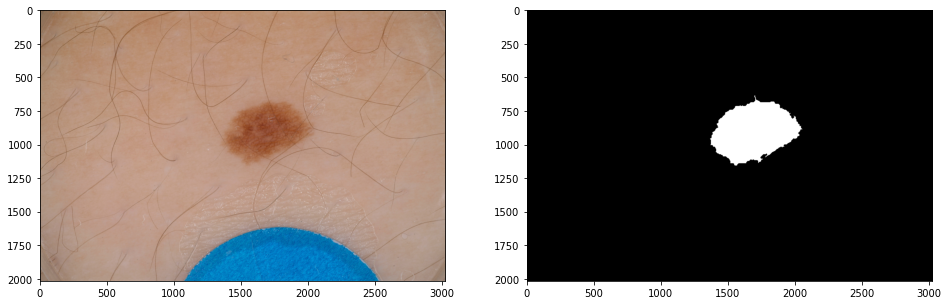

In [11]:
# load test image using PIL
ex_img = DATA['images'][0]
ex_img_mask= DATA['masks'][0]

#size = (1000, 1000)
#ex_img.thumbnail(size)
#ex_img_mask.thumbnail(size)

fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].imshow(ex_img)
ax[1].imshow(ex_img_mask, cmap='gray')

print(ex_img.format, ex_img.size, ex_img.mode)
print(ex_img_mask.format, ex_img_mask.size, ex_img_mask.mode)

314


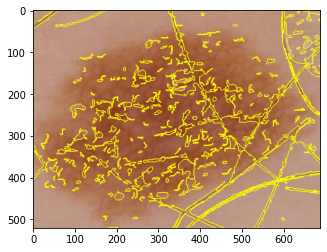

In [12]:
# superpixel algorithm using skimage library
cropped_ex_img = ex_img.crop(ex_img_mask.getbbox())
plt.imshow(cropped_ex_img)
segmentation = felzenszwalb(cropped_ex_img, scale=100)
print(len(np.unique(segmentation)))
plt.imshow(mark_boundaries(cropped_ex_img, segmentation))

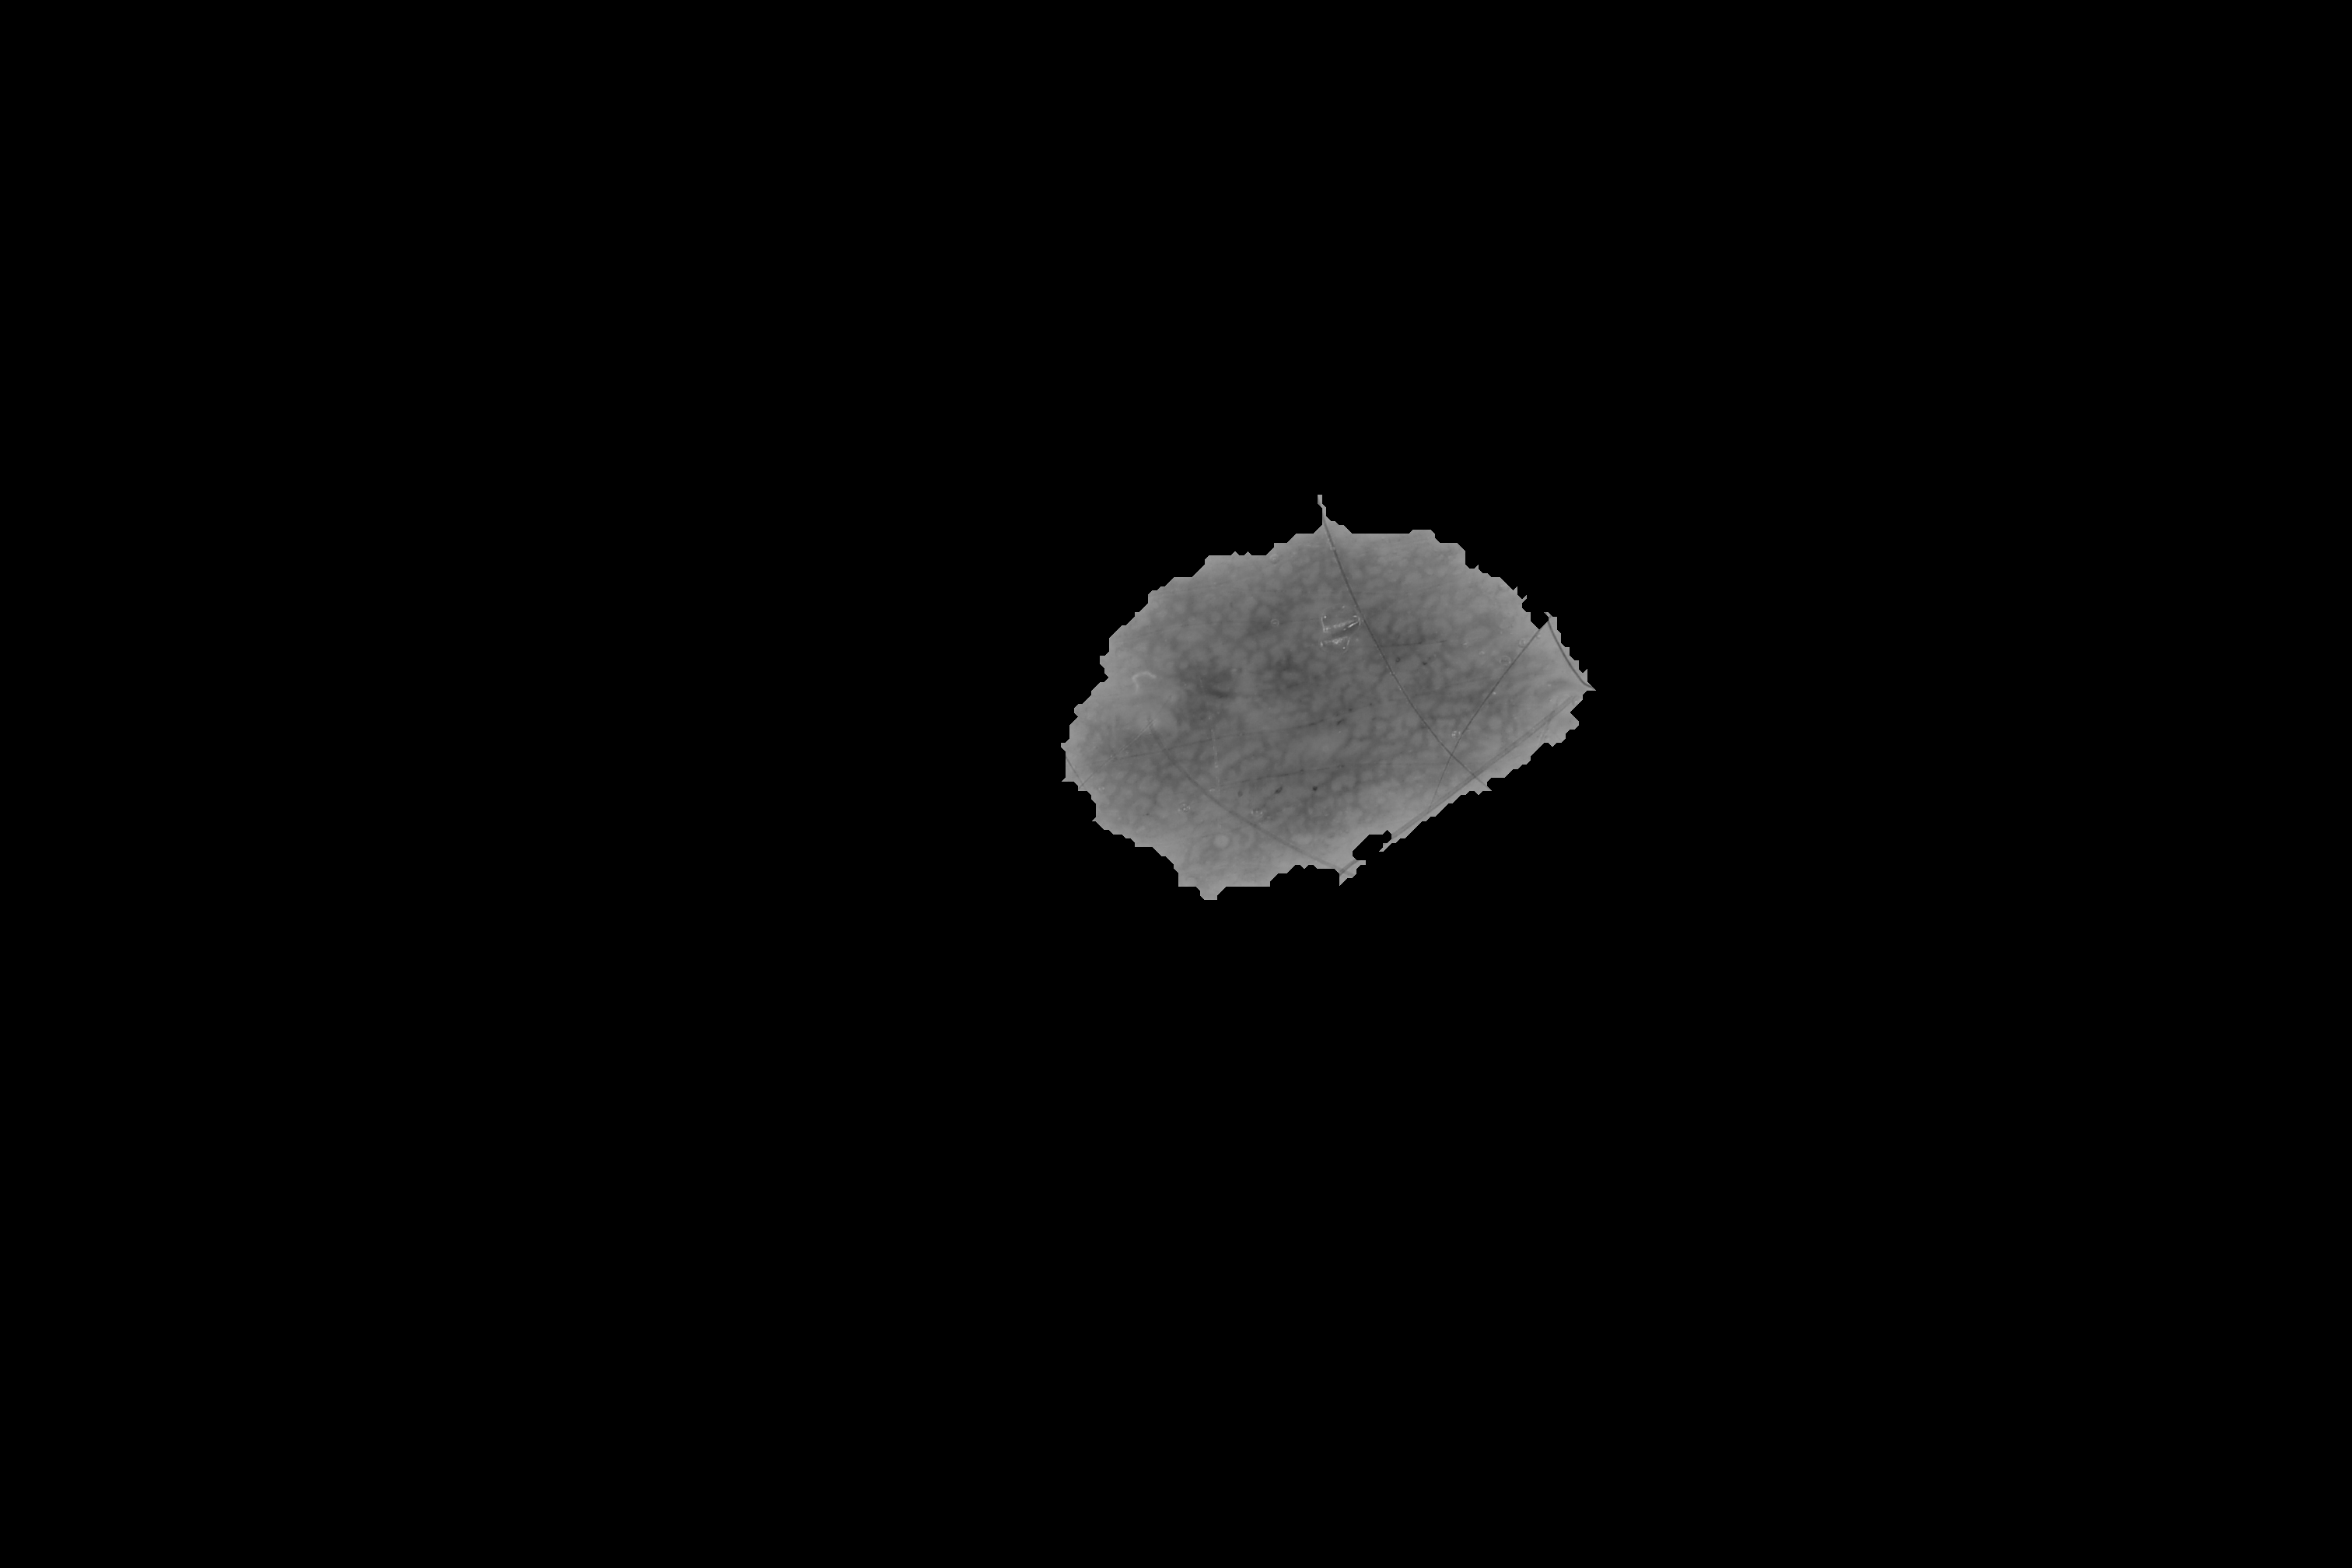

In [13]:
ex_img_mask.size
#https://note.nkmk.me/en/python-pillow-composite/
#non rgb image transforms the final image to greyscale 
testIm = Image.composite(ex_img, ex_img_mask, ex_img_mask)
testIm

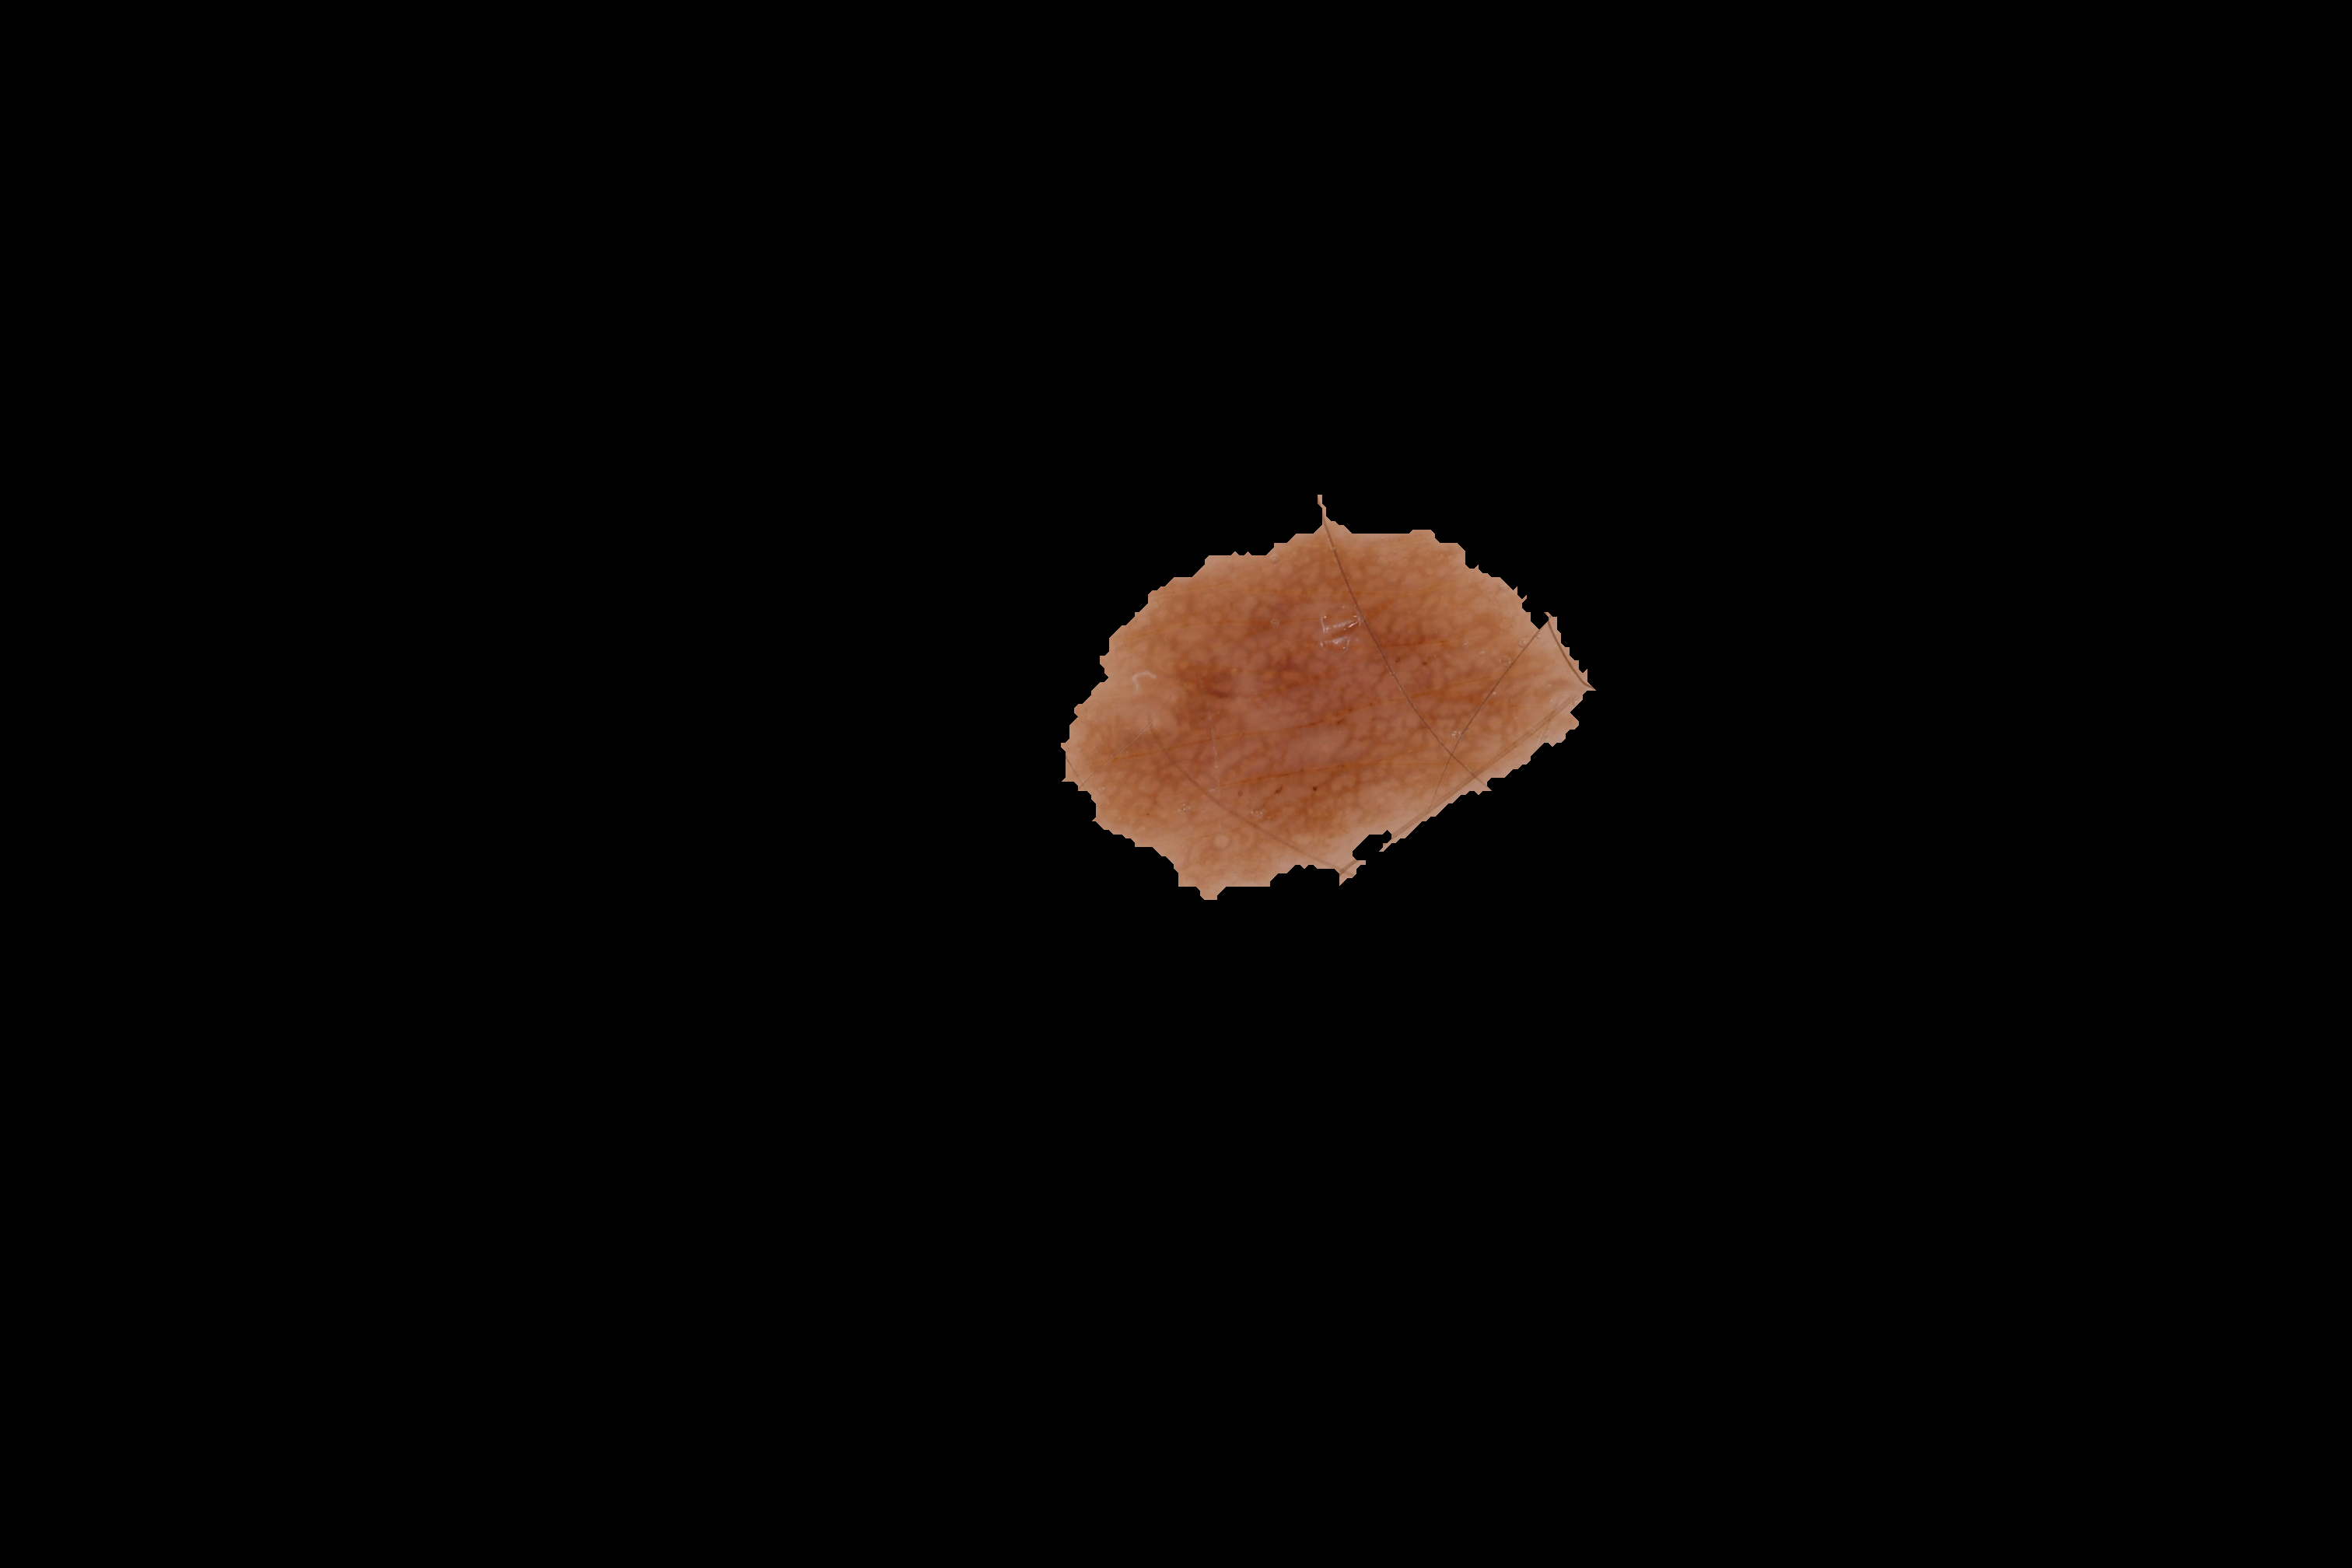

In [14]:
bg = Image.new("RGB", ex_img.size, 0)
testIm = Image.composite(ex_img, bg, ex_img_mask)
testIm

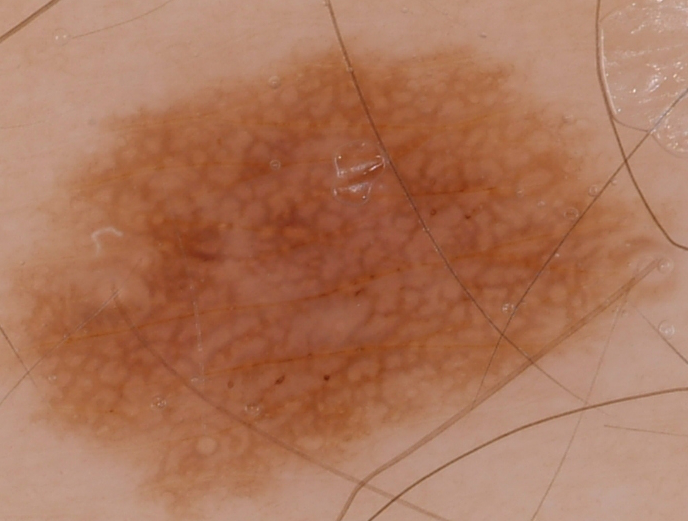

In [15]:
# crop lesion using .getbbox()
ex_img.crop(ex_img_mask.getbbox())

In [16]:
#print(np.array(ex_img.getdata()).shape)

*TASK 1*
# Extracting Features 

---

We need to find quantitative measures of how to best classify the skin cancer type *keratosis*.

A = 

In [17]:
# compactness
def get_compactness(mask):
    area, perimeter = measure_area_perimeter(mask)

    return ( ( perimeter ** 2) / (4 * np.pi * area ) )

In [108]:
compactnesses=[]
for mask in (DATA['masks']):
    compactnesses.append(get_compactness(mask))
print(compactnesses)


[1.4917716658811586, 1.1479187327944576, 1.1477505012847928, 0.8889252134592062, 1.0682540121055242, 0.9417847379802091, 1.2827787099918806, 1.167885479495589, 0.8759341825066632, 0.836119095412628, 0.8456911059299682, 1.6276650332361824, 0.9639489915096933, 0.8698707221224496, 0.8430857116197089, 0.8492861369650451, 0.8902116030285607, 0.8542635558285246, 1.0489076763464227, 0.8071117391493753, 0.8811833302724228, 0.8789748532409832, 1.2387687628089488, 1.0034517924593882, 0.884131257726496, 1.6468852592759675, 1.6985078492675862, 1.6830929548455438, 0.9085119560080689, 1.9634711249632324, 1.78971497616812, 1.9869125911930372, 2.113688238766992, 0.9197889706300006, 1.8015928299000648, 0.9452930339724197, 1.8506568245037345, 2.359918651644775, 1.514549228937526, 1.5542748850180967, 1.4675574737988835, 0.9411583412123536, 1.831305835339323, 1.6638703171235496, 1.5910603366211278, 1.6903236832145232, 1.7323393681432973, 0.8241016264317358, 1.6571312181951252, 1.020761335348686, 1.9776898

In [60]:
#for mask in (DATA['masks']):
#    DATA[['diagnosis'][mask.filename[18:-17]]
diag={}

for index,ident in enumerate(DATA['diagnosis']["image_id"]):
    mel=DATA['diagnosis']["melanoma"][index]
    mole=DATA['diagnosis']["seborrheic_keratosis"][index]
    diag[ident]=[int(mel),int(mole)]

In [87]:
areas=[]
perimeters=[]
#loop = 0
for mask in (DATA['masks']):
    area,perimeter=measure_area_perimeter(mask)
    areas.append(int(area))
    perimeters.append(int(perimeter))


In [97]:
list_of_colours=[]

# for adding the points to the graph, colourised according to their diagnosis (black = nothing, red = melanoma, blue = seborrheic keratosis)
for mask in DATA['masks']:
    area,perimeter=measure_area_perimeter(mask)
    colour="black"
    name_of_file=mask.filename[18:-17]
    # for melanoma
    if diag[name_of_file][0] == 1:
        colour="red"
    # for moles
    if diag[name_of_file][1] == 1:
        colour="blue"
    list_of_colours.append(colour)


        

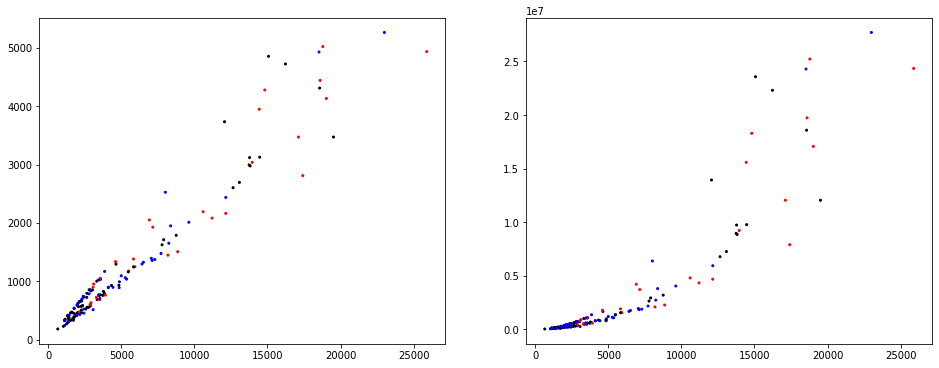

In [107]:
import math
sqrts_of_areas=[math.sqrt(x)for x in areas]
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].scatter(perimeters,sqrts_of_areas,c=list_of_colours,s=4)
ax[1].scatter(perimeters,areas,c=list_of_colours,s=4)


In [69]:
for i in range(5):
    print(get_compactness(DATA['masks'][i]))

1.4917716658811586
1.1479187327944576
1.1477505012847928
0.8889252134592062
1.0682540121055242


In [20]:
circle = Image.open('../data/raw/circle.png')
circle = circle.convert('L')
print(get_compactness(circle))

0.7355539261814622


In [21]:
# color variability
def get_color_var(img):
    pass
    

In [22]:
# average luminance 
def get_average_luminance(img):
    pass

In [23]:
# 

In [24]:
# luminance score (might be a feature)
gray = np.array(testIm.convert('L').getdata())
mask = gray > 0
print(np.mean(gray[mask]))
# plt.hist(gray[mask]) # plot it

114.4909141376758


In [25]:
# asymmetry

In [26]:
# extract single color
r,g,b = testIm.getpixel((1,1))

print(r,g,b)

0 0 0


*TASK 2*
# Predict Diagnosis

---

*TASK 3*
# Open Question: ...

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e5a81e04-857d-4bae-844e-8fb924df483a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>